# Spike Count Analyses

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import convolve

## From spike time to spike counts

In this section, we will explore new Pandas methods that help us to compute spike counts from the already-existing spike time information.

**Pandas**: 
  - `df.groupby("spike_trial")`: This method groups the DataFrame using the "spike_trial" column, where rows with the same "spike_trial" value are bundled together as a single group (i.e. a dataframe). This is particularly useful when you want to perform some operation on each of these groups separately, like summing, averaging, or applying any custom function.
  - `df.groupby(["spike_trial", "spike_cell"])`: Here, the DataFrame is grouped by two columns: "spike_trial" and "spike_cell", where rows with the same "spike_trial" and "spike_cell" value combination are bundled together as a single group (i.e. a dataframe).
  - `df.apply(func)`: Apply a function `func` along the axis of the DataFrame.
  - `df.groupby("spike_trial").apply(func)`: After grouping by "spike_trial," this applies a function func to each group. For instance, using func = len would give the number of rows in each group.
  - `df.groupby("spike_trial").apply(func).reset_index(name="spike_count")`: After grouping and applying the function, reset the index and rename the resulting column to "spike_count".
  - `df[df.spike_time > df.stimulus_onset]`: Filter rows where the "spike_time" is greater than "stimulus_onset".
  - `df[(df.spike_time > df.stimulus_onset) & (df.spike_time < df.response_time)]`: Filter rows based on multiple conditions: where "spike_time" is greater than "stimulus_onset" and less than "response_time".

##### Create a dataframe of spike time data.

In [65]:
dset = xr.load_dataset("../../data/steinmetz_2016-12-14_Cori.nc")

In [66]:
cols = ['spike_trial', 'spike_cell', 'spike_time']
spike_time_df = dset[cols].to_dataframe().reset_index()
spike_time_df

,spike_id,spike_trial,spike_cell,spike_time
0,1,21,1,0.267635
1,2,21,1,2.308335
2,3,31,1,0.853476
3,4,37,1,2.197501
4,5,43,1,2.452692
...,...,...,...,...
2446168,2446169,364,734,0.266459
2446169,2446170,364,734,0.587060
2446170,2446171,364,734,0.618560
2446171,2446172,364,734,2.188634


##### Get the spike count for each trial.

In [67]:
spike_time_df.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,2,1
1,1,8,3
2,1,13,5
3,1,14,28
4,1,15,1
...,...,...,...
191557,364,729,4
191558,364,730,62
191559,364,731,9
191560,364,732,1


##### Get the spike count after stimulus onset.

In [68]:
spike_time_df["stimulus_onset"] = .5
dd = spike_time_df[spike_time_df.spike_time > spike_time_df.stimulus_onset]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,2,1
1,1,8,3
2,1,13,5
3,1,14,21
4,1,15,1
...,...,...,...
182205,364,726,3
182206,364,729,3
182207,364,730,47
182208,364,731,5


##### Get the spike count before response time.

In [69]:
# load the relevant variables
cols = ["response_time", "feedback_time", "gocue", "active_trials"]
experimental_df = dset[cols].to_dataframe().reset_index()
experimental_df = experimental_df[experimental_df.active_trials]

# Merge with the spike time dataframe
experimental_df = experimental_df.rename(columns={"trial": "spike_trial"})
spike_time_df = spike_time_df.merge(experimental_df)
spike_time_df

,spike_id,spike_trial,spike_cell,spike_time,stimulus_onset,response_time,feedback_time,gocue,active_trials
0,1,21,1,0.267635,0.5,2.555003,2.585641,1.049217,True
1,2,21,1,2.308335,0.5,2.555003,2.585641,1.049217,True
2,308,21,2,0.222801,0.5,2.555003,2.585641,1.049217,True
3,309,21,2,0.595668,0.5,2.555003,2.585641,1.049217,True
4,3421,21,7,0.291835,0.5,2.555003,2.585641,1.049217,True
...,...,...,...,...,...,...,...,...,...
1384064,2426915,155,730,2.463472,0.5,2.218932,2.253236,0.714011,True
1384065,2426916,155,730,2.470539,0.5,2.218932,2.253236,0.714011,True
1384066,2444511,155,732,2.176738,0.5,2.218932,2.253236,0.714011,True
1384067,2444512,155,732,2.186038,0.5,2.218932,2.253236,0.714011,True


In [70]:
dd = spike_time_df[spike_time_df.spike_time < spike_time_df.response_time]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,8,1
1,1,13,3
2,1,14,12
3,1,15,1
4,1,16,1
...,...,...,...
97661,214,728,2
97662,214,729,1
97663,214,730,47
97664,214,731,6


##### Get the spike count between stimulus onset and response time.

In [71]:
condition = (spike_time_df.spike_time > spike_time_df.stimulus_onset) & (spike_time_df.spike_time < spike_time_df.response_time)
dd = spike_time_df[condition]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,8,1
1,1,13,3
2,1,14,5
3,1,15,1
4,1,18,6
...,...,...,...
85486,214,727,3
85487,214,728,2
85488,214,729,1
85489,214,730,33


##### Get the spike count between response time and feedback time.

In [72]:
condition = (spike_time_df.spike_time > spike_time_df.response_time) & (spike_time_df.spike_time < spike_time_df.feedback_time)
dd = spike_time_df[condition]
dd.groupby(["spike_trial", "spike_cell"]).apply(len).reset_index(name="spike_count")

,spike_trial,spike_cell,spike_count
0,1,14,1
1,1,18,3
2,1,36,1
3,1,43,1
4,1,59,1
...,...,...,...
11114,214,374,1
11115,214,507,1
11116,214,599,1
11117,214,658,1


## Joint analysis of spike count and Brain areas.

Building on our analyeses so far, now we are going to add more information to our dataframe which allows us to answer questions such as:
- What is the distribution of spike counts across brain areas?
- Is one brain area more active compared to other areas during specific periods of the trial?
- Are there any correlations between population activity across different areas?
<br><br>
- **Seaborn**: Built on top of Matplotlib, it provides a high-level interface for drawing attractive and informative statistical graphics.
  - `sns.boxenplot()`: This plot is an enhanced box plot that shows more quantiles, providing a more detailed view of the data distribution.
  - `sns.stripplot()`: Draws a scatter plot where one variable is categorical, often used to display the distribution of a variable for different categories.
  - `sns.pairplot()`: Creates a matrix of scatter plots for pairwise relationships in the data, and histograms or kernel density plots for each variable along the diagonal.
  - `sns.heatmap()`: Plots a matrix dataset as colored cells to easily identify patterns, often used for displaying correlation matrices or data grids.  
- **Pandas**:
  - `df.pivot_table()`: Create a spreadsheet-style pivot table as a DataFrame. This is useful for summarizing data, where you can specify variables to provide aggregation along the rows and columns.

##### Create a dataframe that contains `brain_area` and `brain_group`.

In [73]:
cols = ["brain_area", "brain_groups"]
brain_area_df = dset[cols].to_dataframe().reset_index()
brain_area_df

,cell,brain_area,brain_groups
0,1,ACA,non-visual cortex
1,2,MOs,non-visual cortex
2,3,ACA,non-visual cortex
3,4,LS,basal ganglia
4,5,MOs,non-visual cortex
...,...,...,...
729,730,SUB,hippocampus
730,731,DG,hippocampus
731,732,DG,hippocampus
732,733,VISp,visual cortex


##### Merge the brain area dataframe with the event dataframe from the last section into a single dataframe

In [75]:
brain_area_df = brain_area_df.rename(columns={"cell": "spike_cell"})
spike_time_df = spike_time_df.merge(brain_area_df)
spike_time_df

,spike_id,spike_trial,spike_cell,spike_time,stimulus_onset,response_time,feedback_time,gocue,active_trials,brain_area,brain_groups
0,1,21,1,0.267635,0.5,2.555003,2.585641,1.049217,True,ACA,non-visual cortex
1,2,21,1,2.308335,0.5,2.555003,2.585641,1.049217,True,ACA,non-visual cortex
2,3,31,1,0.853476,0.5,1.466405,1.502824,0.993616,True,ACA,non-visual cortex
3,4,37,1,2.197501,0.5,2.046424,2.076833,0.530008,True,ACA,non-visual cortex
4,5,43,1,2.452692,0.5,1.083777,1.120418,0.917615,True,ACA,non-visual cortex
...,...,...,...,...,...,...,...,...,...,...,...
1384064,1504956,120,571,1.986953,0.5,1.018032,1.054417,0.816413,True,VISp,visual cortex
1384065,391928,200,272,2.437320,0.5,2.647889,2.685643,1.144018,True,ACA,non-visual cortex
1384066,24780,102,21,0.636550,0.5,1.101693,1.137218,0.990816,True,ACA,non-visual cortex
1384067,391959,167,273,2.305132,0.5,0.952276,0.989216,0.799213,True,ACA,non-visual cortex


##### Create a dataframe that contains the total number spikes sumed across all neurons per area in each trial.

In [76]:
pop_spike_count_df = df.groupby(["spike_trial", "brain_area"]).apply(len).reset_index(name="population_spike_count")
pop_spike_count_df

,spike_trial,brain_area,population_spike_count
0,1,ACA,676
1,1,CA3,754
2,1,DG,566
3,1,LS,1185
4,1,MOs,455
...,...,...,...
1707,214,LS,1267
1708,214,MOs,538
1709,214,SUB,1377
1710,214,VISp,1845


##### Create a strip plot to show the distribution of population spike counts for each brain region across all trials

<Axes: xlabel='brain_area', ylabel='population_spike_count'>

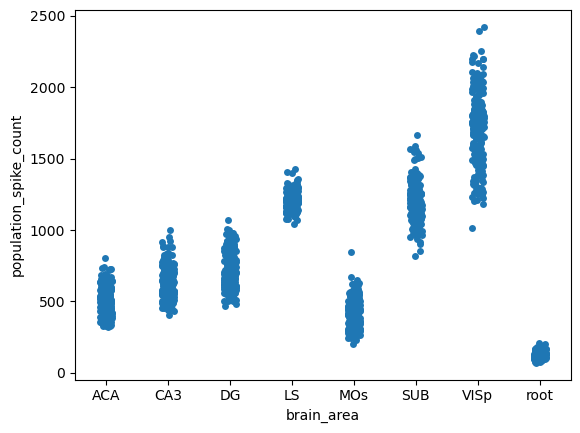

In [77]:
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count")

##### Create a boxen plot for the same data

<Axes: xlabel='brain_area', ylabel='population_spike_count'>

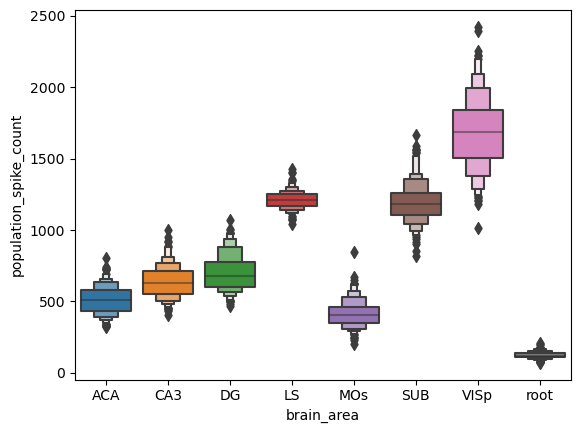

In [78]:
sns.boxenplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count")

##### Overlay the strip plot and the boxen plot in the same plot.

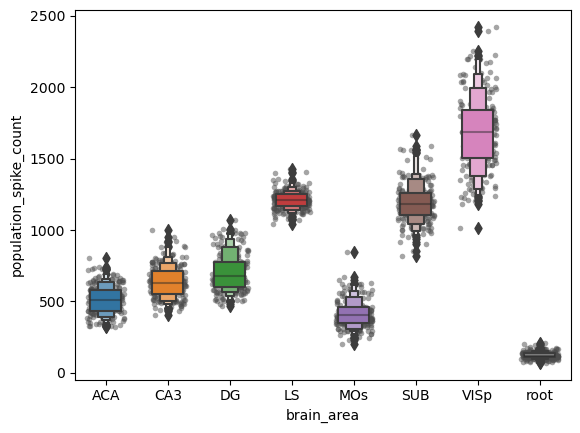

In [79]:
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", size=4, color=".3", alpha=.5, jitter=.3, zorder=0)
ax = sns.boxenplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", width=.5)

##### Are there any correlations between the population spike counts across brain areas?

In [138]:
spike_counts_across_areas = pop_spike_count_df.pivot_table(index="spike_trial", columns="brain_area", values="population_spike_count")

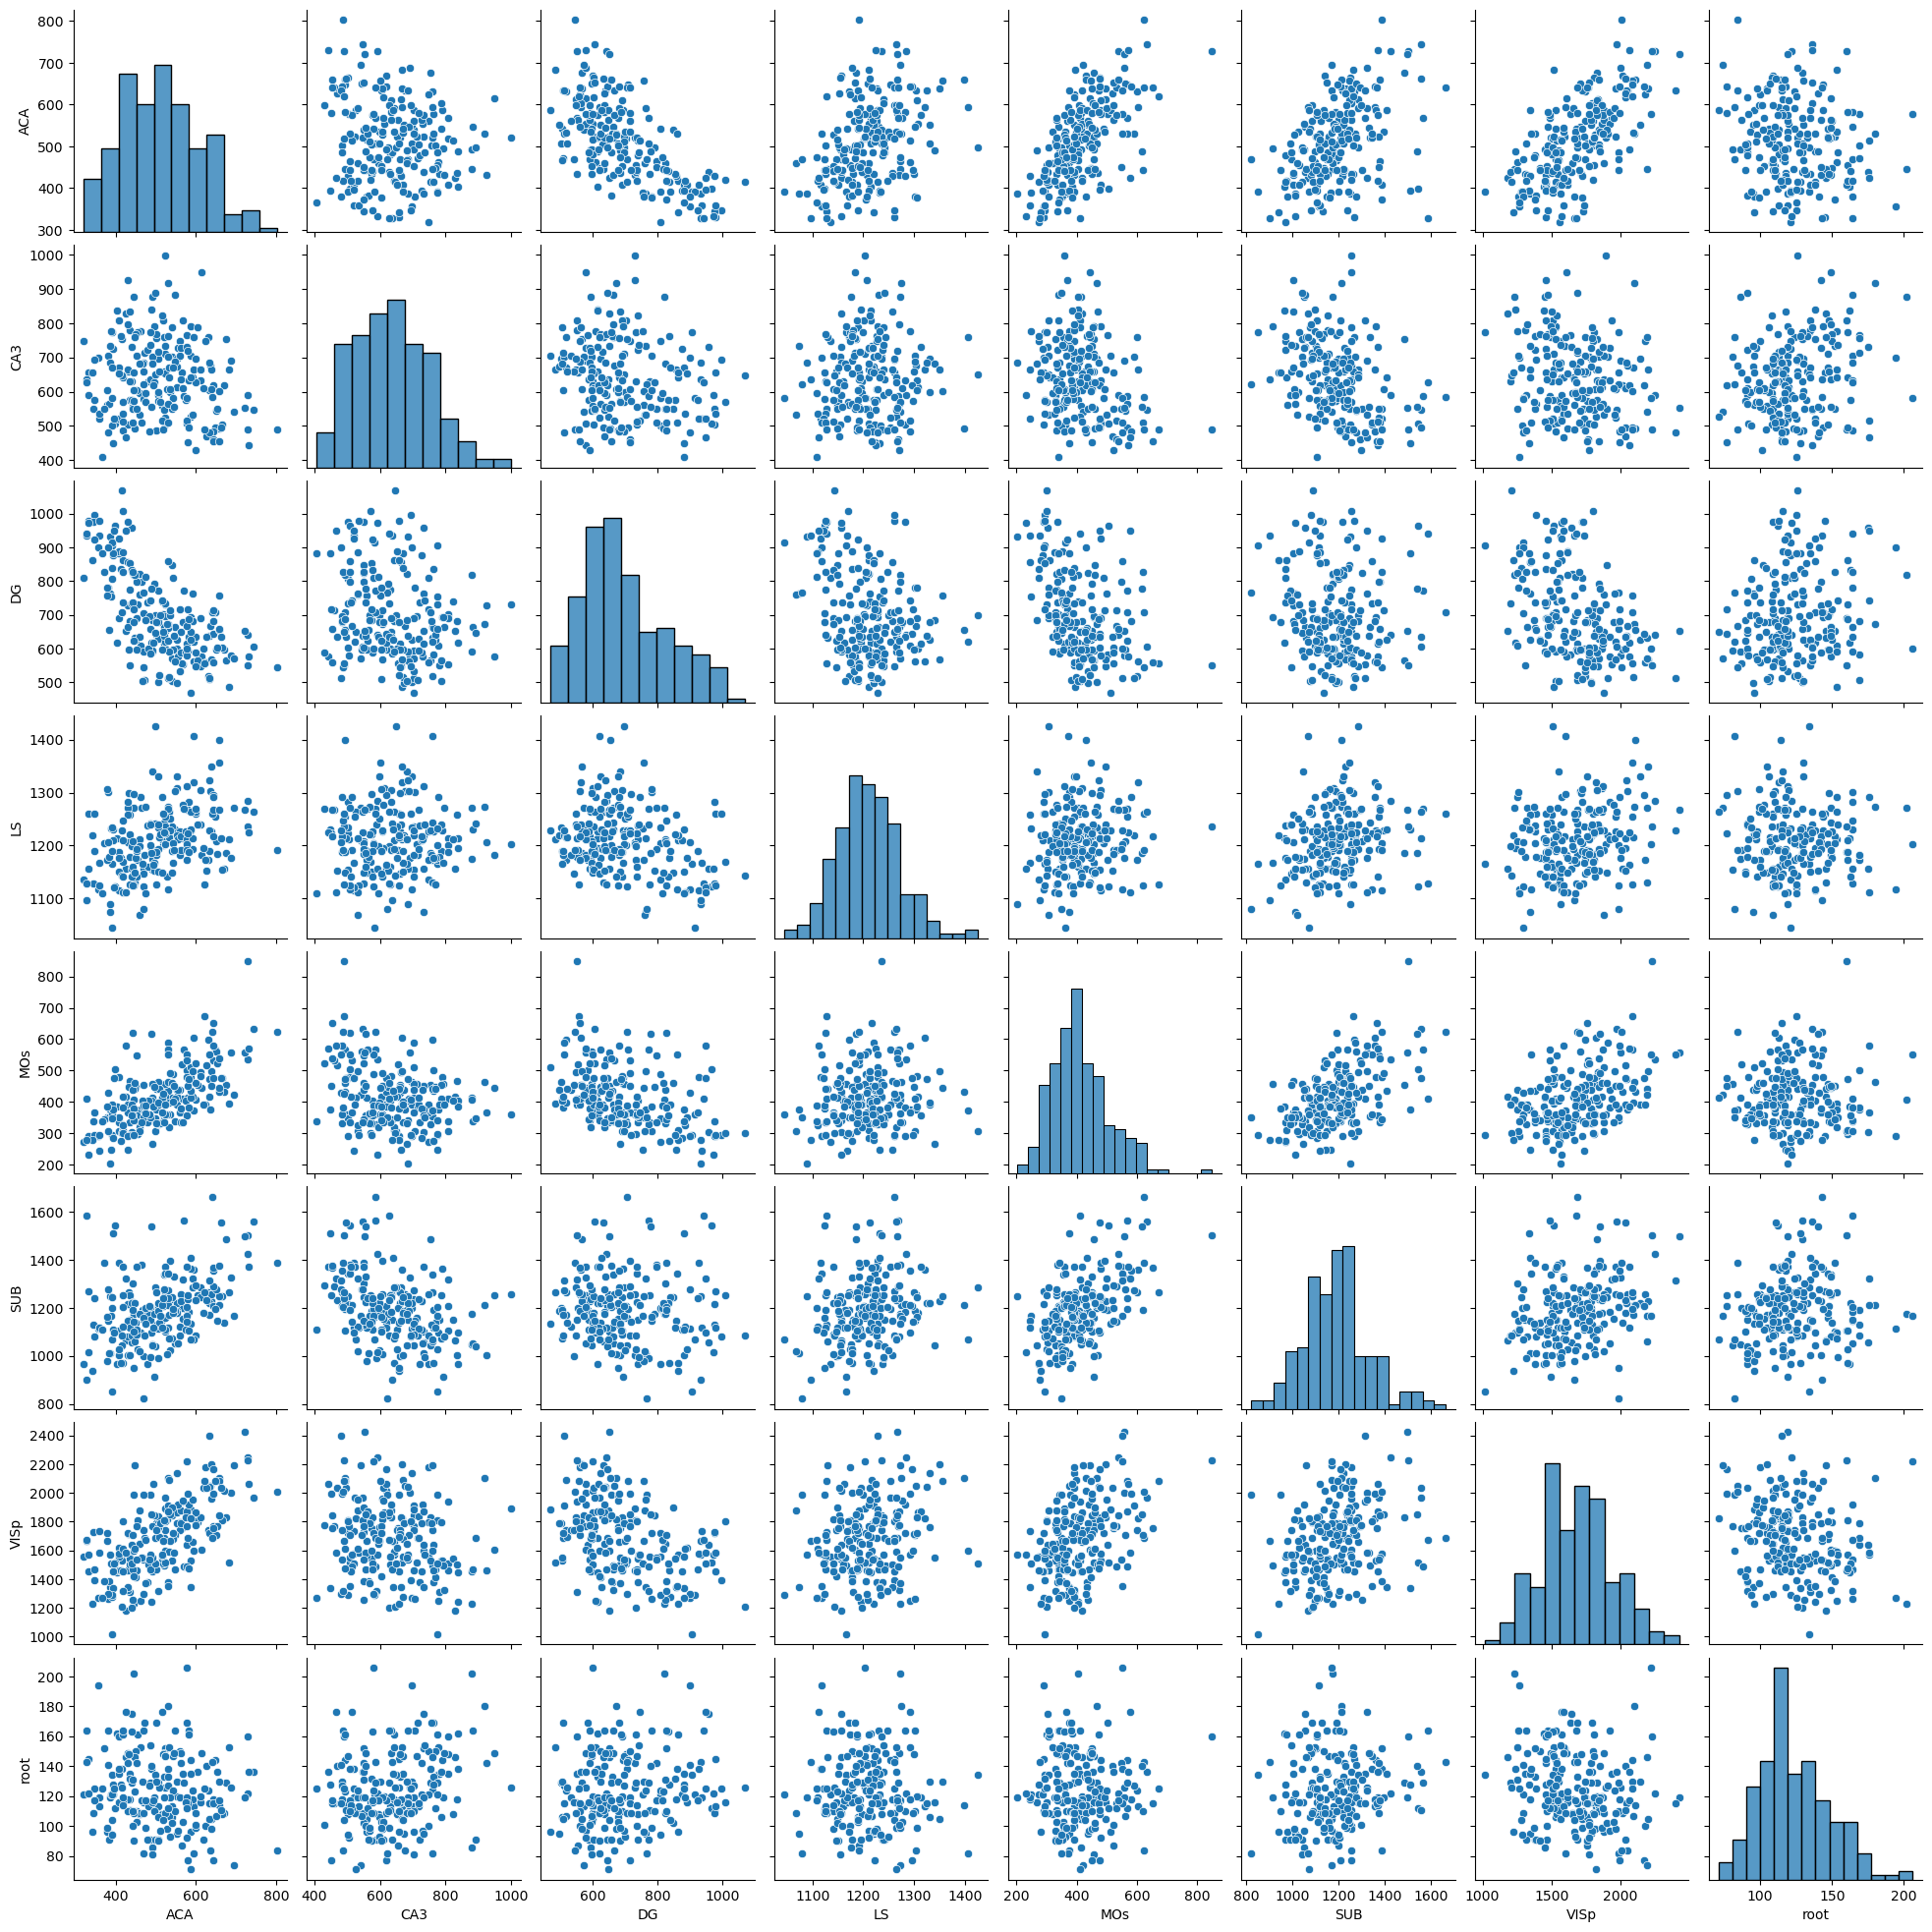

In [139]:
sns.pairplot(data=spike_counts_across_areas)

<Axes: xlabel='brain_area', ylabel='brain_area'>

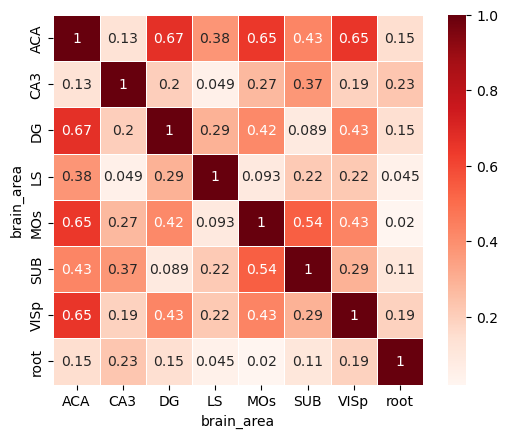

In [149]:
sns.heatmap(spike_counts_across_areas.corr().abs(), annot=True, cmap="Reds", square=True, linewidth=.5)

## Joint analysis of spike count and Brain areas, and other categorical variables (e.g. correct/wrong trials)
Now we are going to add even more information to our dataframe which allows us to answer questions such as:
- Is the spike count in a specific brain area indicative of correct vs wrong choice?
- Is the activity of a specific brain area informative about the subject's decision?
- Does the relationship between different brain areas change depending on the subject's decision? 

##### Add other categorical variables such as `feedback_type` to the dataframe.

In [84]:
cols = ["feedback_type", "response_type"]
feedback_df = dset[cols].to_dataframe().reset_index()
feedback_df = feedback_df.rename(columns={"trial": "spike_trial"})
pop_spike_count_df = pop_spike_count_df.merge(feedback_df)
pop_spike_count_df

,spike_trial,brain_area,population_spike_count,feedback_type,response_type
0,1,ACA,676,1.0,1.0
1,1,CA3,754,1.0,1.0
2,1,DG,566,1.0,1.0
3,1,LS,1185,1.0,1.0
4,1,MOs,455,1.0,1.0
...,...,...,...,...,...
1707,214,LS,1267,-1.0,1.0
1708,214,MOs,538,-1.0,1.0
1709,214,SUB,1377,-1.0,1.0
1710,214,VISp,1845,-1.0,1.0


##### Does the distribution change when conditioned on correct vs wrong trials?

Create three different plots to answer this question"
- bar plot using `sns.barplot()`
- violin plot using `sns.violinplot()`
- strip plot using `sns.stripplot()`

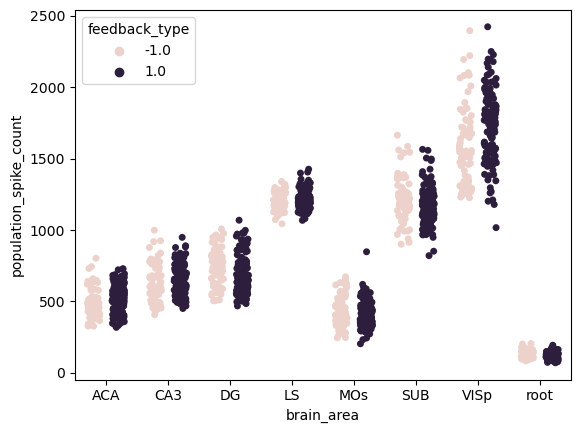

In [85]:
sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", dodge=True, jitter=.2);

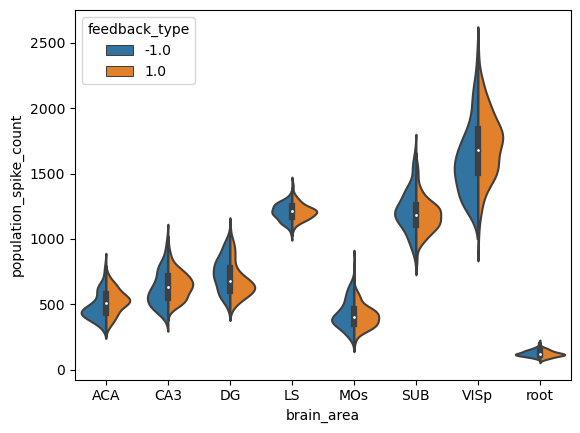

In [87]:
sns.violinplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", split=True);

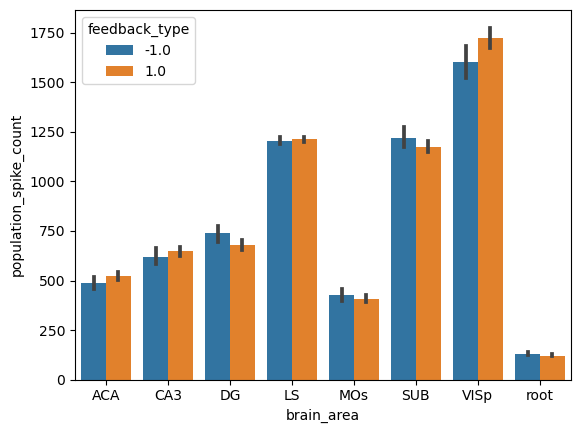

In [88]:
sns.barplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", errorbar=('ci', 99));

##### How does the result change when looking at area groups?

In [105]:
brain_area_df_unique = brain_area_df[["brain_area", "brain_groups"]].drop_duplicates()
pop_spike_count_df = pop_spike_count_df.merge(brain_area_df_unique)
pop_spike_count_df

,spike_trial,brain_area,population_spike_count,feedback_type,response_type,brain_groups
0,1,ACA,676,1.0,1.0,non-visual cortex
1,2,ACA,632,1.0,-1.0,non-visual cortex
2,3,ACA,492,1.0,1.0,non-visual cortex
3,4,ACA,425,1.0,0.0,non-visual cortex
4,5,ACA,578,-1.0,1.0,non-visual cortex
...,...,...,...,...,...,...
1707,210,root,84,-1.0,1.0,root
1708,211,root,115,-1.0,1.0,root
1709,212,root,125,-1.0,0.0,root
1710,213,root,115,-1.0,0.0,root


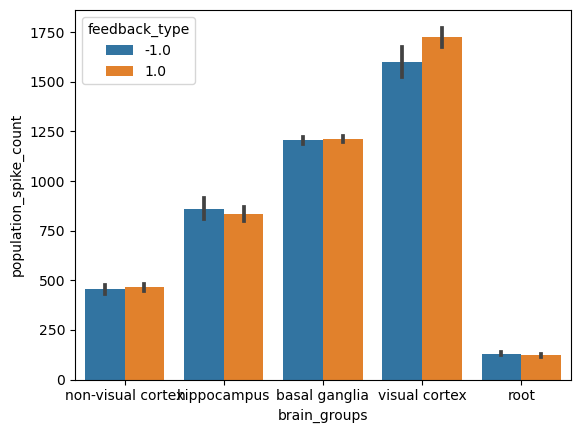

In [106]:
sns.barplot(data=pop_spike_count_df, x="brain_groups", y="population_spike_count", hue="feedback_type", errorbar=("ci", 99));

## Create figures with several panels

In this section we are going to focus on visualizing multiple results in a single figure using subplots (aka panels).

<div style="text-align:center;">
  <img src="figure_anatomy.png" style="height:400px;">
</div>

- **Matplotlib**
  - `fig, ax = plt.subplots()`: Create a single subplot and return the figure (`fig`) and axes (`ax`) objects. You can then plot directly onto `ax`.
  - `fig, axes = plt.subplots(1, 2)`: Create a 1x2 grid of subplots and return the figure and a 1D NumPy array of axes objects. Useful for side-by-side plots.
  - `fig, axes = plt.subplots(3, 2)`: Create a 3x2 grid of subplots. Returns the figure and a 2D NumPy array of axes objects.
  - `axes` is a numpy array and can be indexed accordingly: When you have multiple subplots, you can index into the `axes` array to get individual `ax` objects for specific subplots. For example, `axes[0, 0]` would give you the axes object for the subplot in the first row and first column.

These lines set up the figure and axes objects which serve as the canvas for your Matplotlib visualizations. By knowing how to manipulate these objects, you can create complex multi-subplot figures and have better control over the layout.

##### In the last section you plotted the distribution change when conditioned on correct vs wrong trials with three different plotting functions. Let's put all of those into a single figure beside each other.

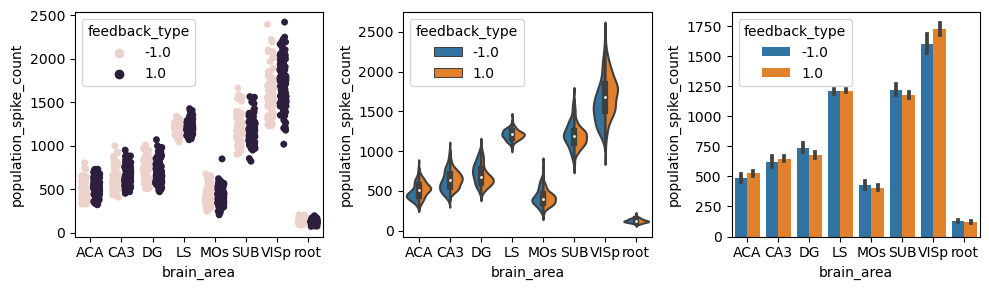

In [127]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", dodge=True, jitter=.2, ax=ax1);
sns.violinplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", split=True, ax=ax2);
sns.barplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", errorbar=('ci', 99), ax=ax3);

fig.tight_layout()

##### Let's do the same thing but instead place them on top of each other.

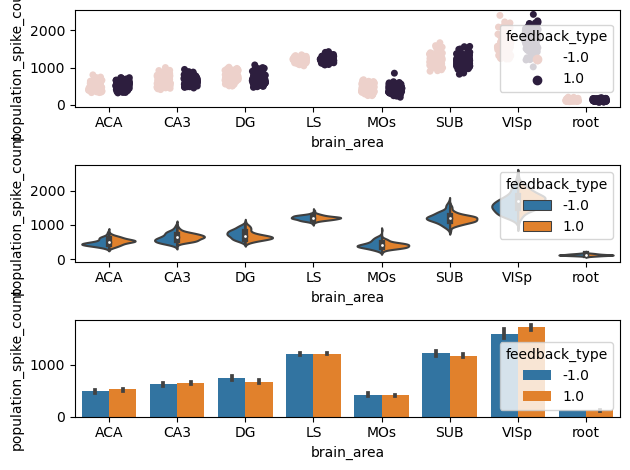

In [146]:
fig, axes = plt.subplots(3, 1)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

sns.stripplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", dodge=True, jitter=.2, ax=ax1);
sns.violinplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", split=True, ax=ax2);
sns.barplot(data=pop_spike_count_df, x="brain_area", y="population_spike_count", hue="feedback_type", errorbar=('ci', 99), ax=ax3);

fig.tight_layout()